In [1]:
import os
if 'ROOT_PATH' in os.environ:
    ROOT_PATH = os.environ['ROOT_PATH']
else:
    ROOT_PATH = '/homes/ar2342/one_more_dir/contextual_frogs/'
    os.environ['ROOT_PATH'] = ROOT_PATH
    
import sys
sys.path.append(ROOT_PATH)

In [2]:
'''
bringup of oprimisation run #21
'''

'\nbringup of oprimisation run #21\n'

In [3]:
from coin_if import COINWrapper,read_COIN_params

In [4]:
from __future__ import absolute_import
import importlib


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from models import MLP, OneOverSqr
from runners import wrap_runner_for_optimization
from fitting_utils import create_fitting_loss
from dsp_utils import smooth_signal

from types import SimpleNamespace

In [5]:
# from coin_if import read_COIN_params
# raw_coin_params = read_COIN_params('/fitted_parameters/')

In [6]:
args = SimpleNamespace()
args.paradigm = ['evoked', 'spontaneous']

paradigm_short = {
    'evoked': 'E',
    'spontaneous': 'S'
}

paradigm_info = {
    'evoked': {
        'i_min': 1,
        'i_max': 8,},

    'spontaneous': {
        'i_min': 1,
        'i_max': 8,}
    }



In [7]:
data = {}
opt_data = {}
paradigm_by_id_lut = {}
id = 0
# param_names = [k for k in raw_coin_params['E1'].keys()]

if type(args.paradigm) is not str:
    for paradigm in args.paradigm:
        for i in range(paradigm_info[paradigm]['i_min'],paradigm_info[paradigm]['i_max']+1):
            # with open(f'../results/sweek_with_shift_{i}.pkl','rb') as f:
            # with open(f'{ROOT_PATH}/experimental/coin_{args.paradigm}_run011s_MSE_{i}.pkl','rb') as f:
            with open(f'{ROOT_PATH}/results/coin_{paradigm}_run021_MSE_{i}.pkl','rb') as f:
                opt_data[id] = pickle.load(f)
            # kk = paradigm_short[paradigm]+str(i)
            # opt_data[id] = {'MSE':{'x':[raw_coin_params[kk][p] for p in param_names]}}
            
            paradigm_by_id_lut[id] = paradigm

            df = pd.read_csv(f'{ROOT_PATH}/../../frogs_project/data/COIN_data/trial_data_{paradigm}_recovery_participant{i}.csv')
            y = df.Adaptation.to_numpy()
            y *= np.sign(np.nansum(y))
            data[id] = y

            id += 1

In [8]:
opt_data

{0: {'MSE':                     message: ['requested number of basinhopping iterations completed successfully']
                      success: False
                          fun: 0.004830391004359091
                            x: [-3.000e+00 -1.000e-01  5.000e-01  8.386e-01
                                 5.886e-01]
                          nit: 200
        minimization_failures: 44
                         nfev: 26190
                         njev: 4365
   lowest_optimization_result:  message: ABNORMAL_TERMINATION_IN_LNSRCH
                                success: False
                                 status: 2
                                    fun: 0.004830391004359091
                                      x: [-3.000e+00 -1.000e-01  5.000e-01
                                           8.386e-01  5.886e-01]
                                    nit: 0
                                    jac: [       nan        nan        nan
                                                 nan   

In [9]:
def scale_and_bias(x,bias=0,scale=45.0):
    x = np.array(x)
    return x*scale + bias
fixed_params = {}


fixed_params['model'] =  dict(n_inputs = 4,
                        n_hidden = 5*4*512,
                        n_outs = 1,
                        en_bias = False,
                        first_layer_init='uniform_unity',
                    first_layer_weights_trainable = True,
                    out_layer_init='zeros',
                        nl = 'relu')        

fixed_params['runner'] = {'criterion':'MSE', 'k':[0,0,0,1],  'sigma_noi':0.0, 'tau_u':1,
                        'save_model_at_init':False, 'ic_param_file':None, 'enable_combo':True}



optim_param_mapping= [('custom','normalized_log_lr'),
                    ('model','skip_gain'),                      
                    ('model','b_high'),                      
                    ('postprocessing','scale'),
                    ('custom','log_wdecay_rate')
                    ]
custom_param_mappings = [{'cathegory':'runner','param_name':'learning_rate',
                        'fun': lambda x: 10.**x['normalized_log_lr']},
                        {'cathegory':'runner','param_name':'optimizer_opts',
                        'fun': lambda x: {'weight_decay': 10.**x['log_wdecay_rate']} },
                        ]

wrapped_runner = wrap_runner_for_optimization(model_class=MLP, 
                                             fixed_params=fixed_params,
                                             optim_params_mapping=optim_param_mapping,
                                              custom_param_mappings =custom_param_mappings,
                                             postprocessing_fun=scale_and_bias)


In [10]:
Pplus = 1
Pminus = -1
P0 = 0
Pchannel = np.nan

'''
spontaneous:
trials in block Null: 50
trials in block FieldA: 120
trials in block PostRest: 5
trials in block FieldB: 15
trials in block Clamp150: 150


evoked:
trials in block Null: 50
trials in block FieldA: 120
trials in block PostRest: 5
trials in block FieldB: 15
trials in block Clamp2: 2
trials in block FieldA2: 2
trials in block Clamp150: 146
'''
stimuli = {'spontaneous': [(P0, 50),
                        (Pplus, 125),
                        (Pminus, 15),
                        (Pchannel, 150)],
            'evoked': [(P0, 50),
                        (Pplus, 125),
                        (Pminus, 15),
                        (Pchannel, 2),
                        (Pplus, 2),
                        (Pchannel, 146)]}

# data = {}
# id = 0
# for , paradigm in paradigm_by_id_lut.items():
    
# stimulus = stimuli[args.paradigm]
datapoint_mapping=None

In [11]:
pooling_fun = 'MSE'

In [12]:
outs  = {k: wrapped_runner(stimuli[paradigm_by_id_lut[k]],opt_data[k][pooling_fun]['x']) for k in opt_data}

Text(0.5, 1.0, 'subjects -->>1')

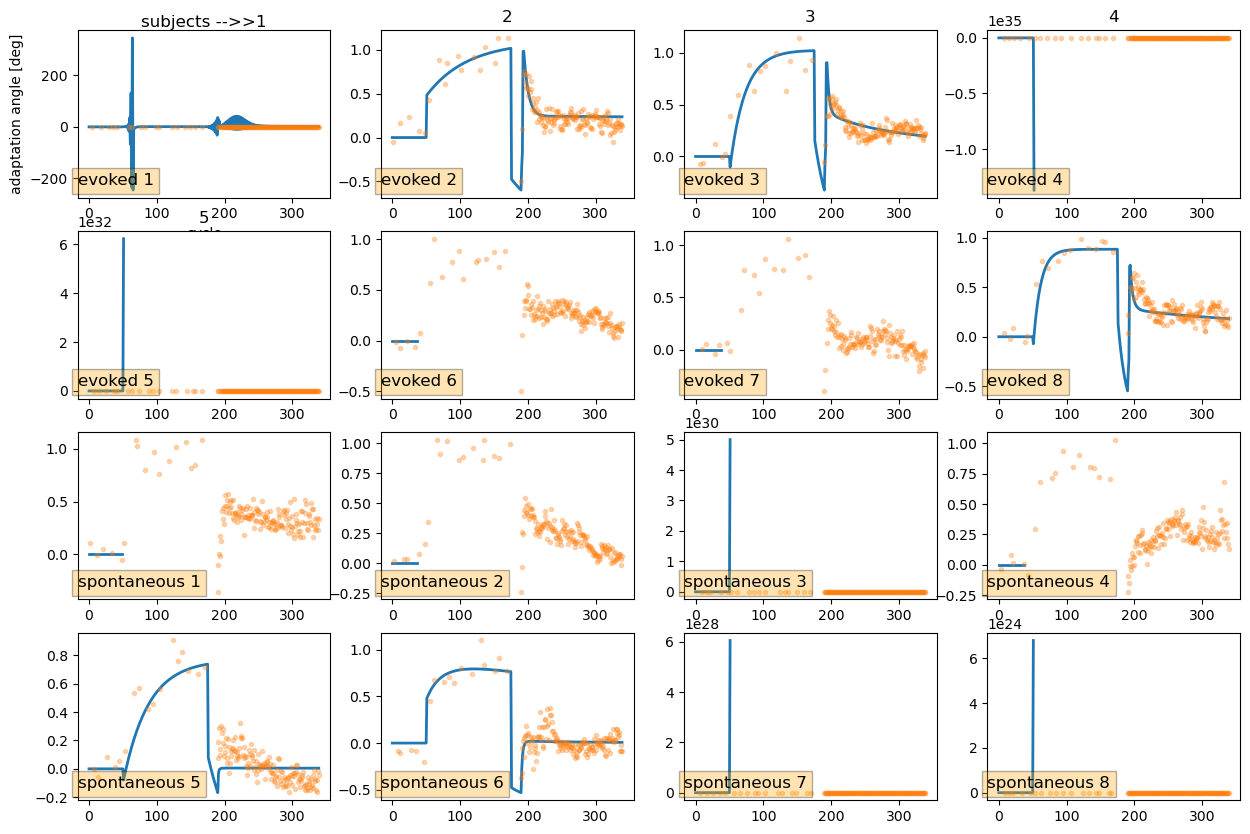

In [13]:
plt.figure(figsize=(15,10))
for k in opt_data:
    plt.subplot(4,4,k+1)
    ydata_model = outs[k]
    xdata_model = np.arange(1,len(ydata_model)+1)
    ydata_experiment = data[k]
    xdata_experiment = np.arange(1,len(ydata_experiment)+1)
    #remove nans
    xdata_model = xdata_model[~np.isnan(ydata_model)]
    ydata_model = ydata_model[~np.isnan(ydata_model)]
    xdata_experiment = xdata_experiment[~np.isnan(ydata_experiment)]
    ydata_experiment = ydata_experiment[~np.isnan(ydata_experiment)]
    # output as csv
    # np.savetxt(f'{ROOT_PATH}/results/coin_fit12_subj_{k+1}_model.csv', np.array([xdata_model,ydata_model]).T, delimiter=',')
    # np.savetxt(f'{ROOT_PATH}/results/coin_fit12_subj_{k+1}_experiment.csv', np.array([xdata_experiment,ydata_experiment]).T, delimiter=',')

    plt.plot(outs[k],linewidth=2)
    plt.plot(data[k],'.', alpha=0.3)
    if k<5: plt.title(f'{k+1}')
    plt.text(0.0, 0.1, f'{paradigm_by_id_lut[k]} {k%8+1}', 
                 horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12,
                 bbox=dict(facecolor='orange', alpha=0.3))



plt.subplot(4,4,1)
plt.ylabel('adaptation angle [deg]')
plt.xlabel('cycle')

plt.gca().set_title(f'subjects -->>{1}', pad=-30)



# plt.legend(['model','validation data','fitted data'])    
    
# plt.plot(data[:80,0],'.')
# plt.plot(smooth_signal(data[:,0],3))


In [30]:
opt_data[8]['MSE']['x']

array([-3.        ,  0.9023659 ,  0.5       ,  0.5       ,  3.79844093])

Text(0.5, 1.0, 'subjects -->>1')

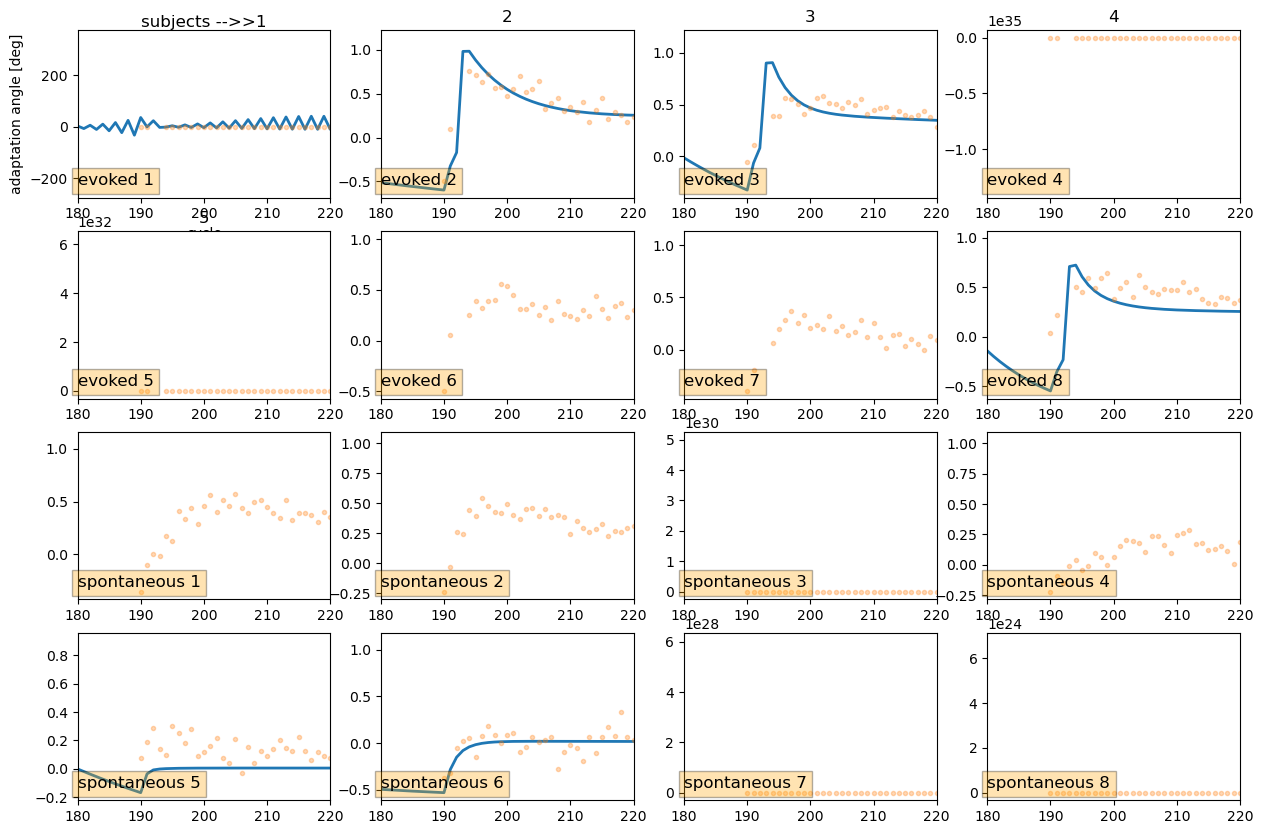

In [14]:
plt.figure(figsize=(15,10))
for k in opt_data:
    plt.subplot(4,4,k+1)
    ydata_model = outs[k]
    xdata_model = np.arange(1,len(ydata_model)+1)
    ydata_experiment = data[k]
    xdata_experiment = np.arange(1,len(ydata_experiment)+1)
    #remove nans
    xdata_model = xdata_model[~np.isnan(ydata_model)]
    ydata_model = ydata_model[~np.isnan(ydata_model)]
    xdata_experiment = xdata_experiment[~np.isnan(ydata_experiment)]
    ydata_experiment = ydata_experiment[~np.isnan(ydata_experiment)]
    # output as csv
    # np.savetxt(f'{ROOT_PATH}/results/coin_fit12_subj_{k+1}_model.csv', np.array([xdata_model,ydata_model]).T, delimiter=',')
    # np.savetxt(f'{ROOT_PATH}/results/coin_fit12_subj_{k+1}_experiment.csv', np.array([xdata_experiment,ydata_experiment]).T, delimiter=',')

    plt.plot(outs[k],linewidth=2)
    plt.plot(data[k],'.', alpha=0.3)
    if k<5: plt.title(f'{k+1}')
    plt.text(0.0, 0.1, f'{paradigm_by_id_lut[k]} {k%8+1}', 
                 horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12,
                 bbox=dict(facecolor='orange', alpha=0.3))
    plt.xlim([180,220])


plt.subplot(4,4,1)
plt.ylabel('adaptation angle [deg]')
plt.xlabel('cycle')

plt.gca().set_title(f'subjects -->>{1}', pad=-30)



# plt.legend(['model','validation data','fitted data'])    
    
# plt.plot(data[:80,0],'.')
# plt.plot(smooth_signal(data[:,0],3))
 


Text(0.5, 1.0, 'subjects -->>1')

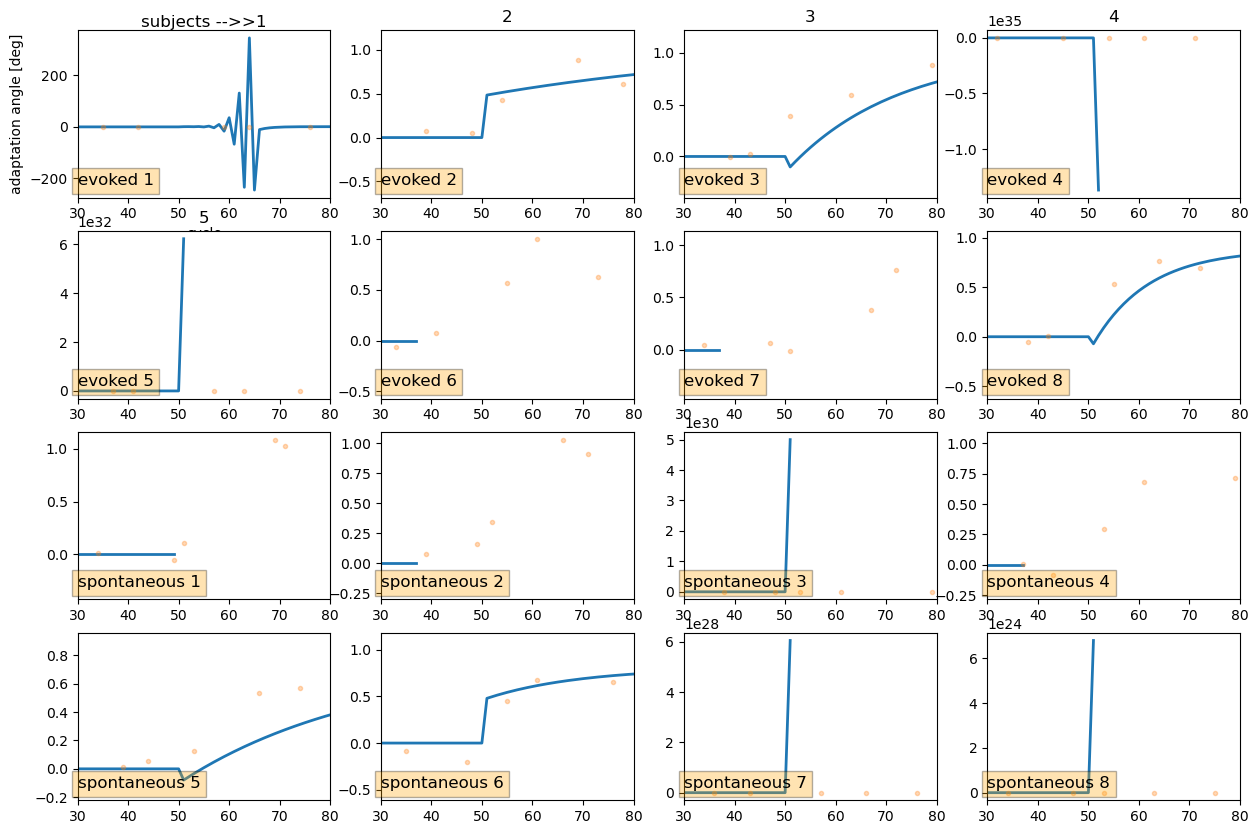

In [15]:
plt.figure(figsize=(15,10))
for k in opt_data:
    plt.subplot(4,4,k+1)
    ydata_model = outs[k]
    xdata_model = np.arange(1,len(ydata_model)+1)
    ydata_experiment = data[k]
    xdata_experiment = np.arange(1,len(ydata_experiment)+1)
    #remove nans
    xdata_model = xdata_model[~np.isnan(ydata_model)]
    ydata_model = ydata_model[~np.isnan(ydata_model)]
    xdata_experiment = xdata_experiment[~np.isnan(ydata_experiment)]
    ydata_experiment = ydata_experiment[~np.isnan(ydata_experiment)]
    # output as csv
    # np.savetxt(f'{ROOT_PATH}/results/coin_fit12_subj_{k+1}_model.csv', np.array([xdata_model,ydata_model]).T, delimiter=',')
    # np.savetxt(f'{ROOT_PATH}/results/coin_fit12_subj_{k+1}_experiment.csv', np.array([xdata_experiment,ydata_experiment]).T, delimiter=',')

    plt.plot(outs[k],linewidth=2)
    plt.plot(data[k],'.', alpha=0.3)
    if k<5: plt.title(f'{k+1}')
    plt.text(0.0, 0.1, f'{paradigm_by_id_lut[k]} {k%8+1}', 
                 horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12,
                 bbox=dict(facecolor='orange', alpha=0.3))
    plt.xlim([30,80])


plt.subplot(4,4,1)
plt.ylabel('adaptation angle [deg]')
plt.xlabel('cycle')

plt.gca().set_title(f'subjects -->>{1}', pad=-30)


Text(0.5, 1.0, 'subjects -->>1')

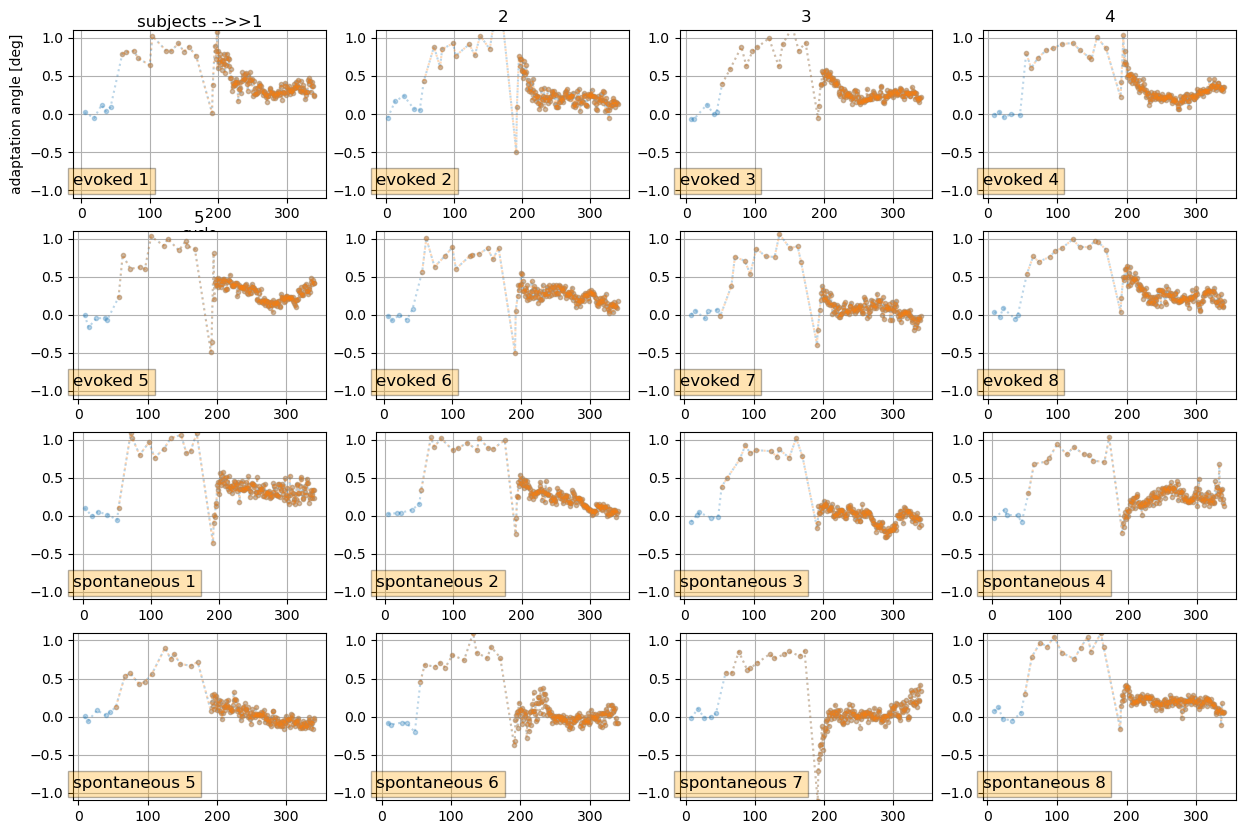

In [16]:
plt.figure(figsize=(15,10))
for k in opt_data:
    plt.subplot(4,4,k+1)
    ydata_model = outs[k]
    xdata_model = np.arange(1,len(ydata_model)+1)
    ydata_experiment = data[k]
    xdata_experiment = np.arange(1,len(ydata_experiment)+1)
    #remove nans
    xdata_model = xdata_model[~np.isnan(ydata_model)]
    ydata_model = ydata_model[~np.isnan(ydata_model)]
    xdata_experiment = xdata_experiment[~np.isnan(ydata_experiment)]
    ydata_experiment = ydata_experiment[~np.isnan(ydata_experiment)]
    # output as csv
    # np.savetxt(f'{ROOT_PATH}/results/coin_fit12_subj_{k+1}_model.csv', np.array([xdata_model,ydata_model]).T, delimiter=',')
    # np.savetxt(f'{ROOT_PATH}/results/coin_fit12_subj_{k+1}_experiment.csv', np.array([xdata_experiment,ydata_experiment]).T, delimiter=',')

    # plt.plot(outs[k],linewidth=2)
    nonans = np.logical_not(np.isnan(xdata_experiment))
    tge51 = np.logical_and(xdata_experiment>50,nonans)
    plt.plot(xdata_experiment[nonans],ydata_experiment[nonans],':.', alpha=0.3)
    plt.plot(xdata_experiment[tge51],ydata_experiment[tge51],':.', alpha=0.3)
    if k<5: plt.title(f'{k+1}')
    plt.text(0.0, 0.1, f'{paradigm_by_id_lut[k]} {k%8+1}', 
                 horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12,
                 bbox=dict(facecolor='orange', alpha=0.3))

    plt.ylim([-1.1,1.1])
    plt.grid()


plt.subplot(4,4,1)
plt.ylabel('adaptation angle [deg]')
plt.xlabel('cycle')
plt.gca().set_title(f'subjects -->>{1}', pad=-30)



# plt.legend(['model','validation data','fitted data'])    
    
# plt.plot(data[:80,0],'.')
# plt.plot(smooth_signal(data[:,0],3))

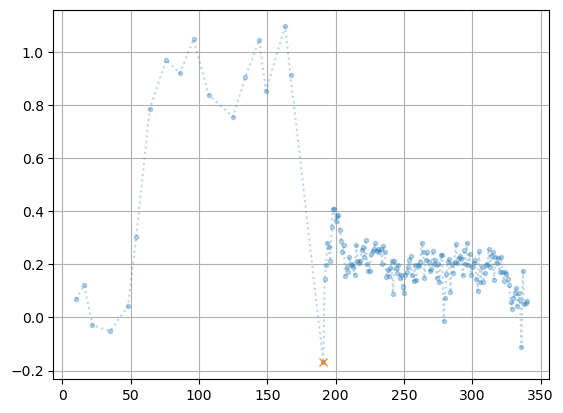

In [17]:
Tc1 = 191
plt.plot(xdata_experiment[nonans],ydata_experiment[nonans],':.', alpha=0.3)
plt.plot(Tc1,ydata_experiment[xdata_experiment==Tc1],'x', alpha=0.9)
plt.grid()

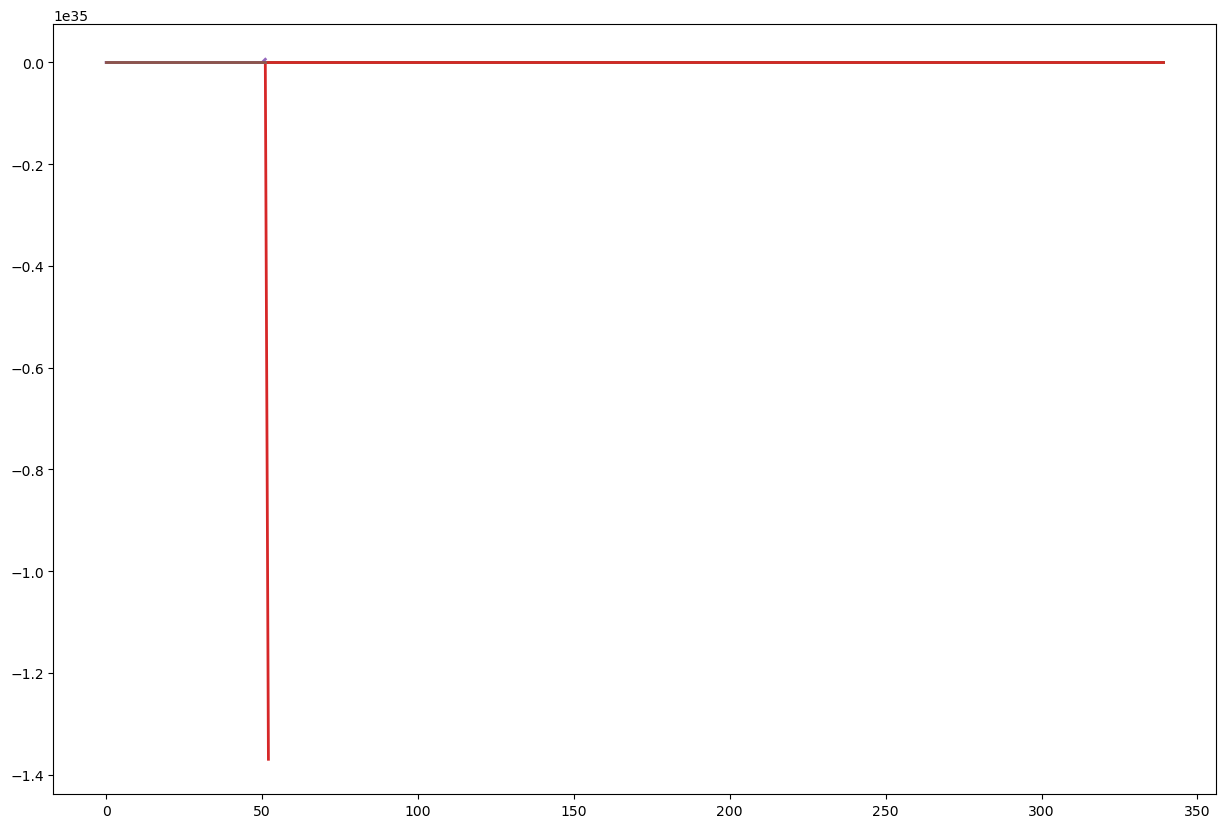

In [18]:
plt.figure(figsize=(15,10))
for k in opt_data:
    # plt.subplot(4,4,k+1)
    ydata_model = outs[k]
    xdata_model = np.arange(1,len(ydata_model)+1)
    ydata_experiment = data[k]
    xdata_experiment = np.arange(1,len(ydata_experiment)+1)
    #remove nans
    xdata_model = xdata_model[~np.isnan(ydata_model)]
    ydata_model = ydata_model[~np.isnan(ydata_model)]
    xdata_experiment = xdata_experiment[~np.isnan(ydata_experiment)]
    ydata_experiment = ydata_experiment[~np.isnan(ydata_experiment)]
    # output as csv
    # np.savetxt(f'{ROOT_PATH}/results/coin_fit12_subj_{k+1}_model.csv', np.array([xdata_model,ydata_model]).T, delimiter=',')
    # np.savetxt(f'{ROOT_PATH}/results/coin_fit12_subj_{k+1}_experiment.csv', np.array([xdata_experiment,ydata_experiment]).T, delimiter=',')

    plt.plot(outs[k],linewidth=2)
    # plt.plot(data[k],'.', alpha=0.3)
    # if k<5: plt.title(f'{k+1}')
    # plt.text(0.0, 0.1, f'{paradigm_by_id_lut[k]} {k%8+1}', 
    #              horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12,
    #              bbox=dict(facecolor='orange', alpha=0.3))



# plt.subplot(4,4,1)
# # plt.ylabel('adaptation angle [deg]')
# # plt.xlabel('cycle')

# plt.gca().set_title(f'subjects -->>{1}', pad=-30)

In [19]:
len(xdata_experiment)

167

In [20]:
A_times = [0,5,10,20] 
antero_short   = {aa: [ wrapped_runner([(1,A_time),(-1,40)],opt_data[k][pooling_fun]['x']) for k in opt_data] for aa,A_time in enumerate(A_times)}

/homes/ar2342/one_more_dir/contextual_frogs/runners.py:294: RuntimeWarning: invalid value encountered in double_scalars
  err_t]+([self.u_lp.state + err_t] if self.enable_combo else []))
/homes/ar2342/one_more_dir/contextual_frogs/runners.py:231: RuntimeWarning: invalid value encountered in multiply
  model_input = self.k*x_tm1
/homes/ar2342/one_more_dir/contextual_frogs/dsp_utils.py:9: RuntimeWarning: invalid value encountered in double_scalars
  self.state = 1./self.tau*x + (1-1./self.tau)*self.state


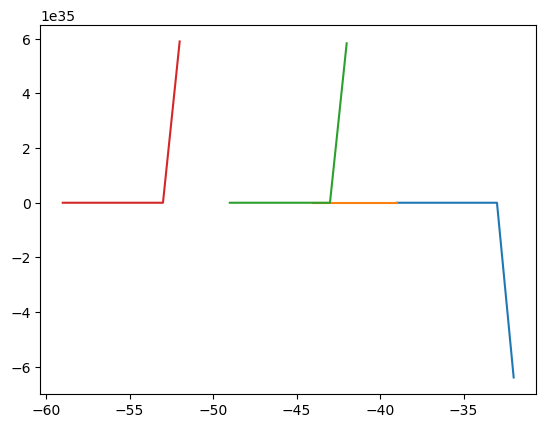

In [21]:
for aa,A_time in enumerate(A_times):
    y = np.mean(antero_short[aa],axis=0)
    x = np.arange(len(y))
    x = x - x[-1]
    plt.plot(x,y)
    

In [22]:
TaN=150
TaB=120

ref_antero_playlist = {'AB0':[(P0, TaN),(Pminus, TaB)],
'AB1':[(P0, TaN),(Pplus,13),(Pminus, TaB)],
'AB2':[(P0, TaN),(Pplus,41),(Pminus, TaB)],
'AB3':[(P0, TaN),(Pplus,112),(Pminus, TaB)],
'AB4':[(P0, TaN),(Pplus,230),(Pminus, TaB)],
'AB5':[(P0, TaN),(Pplus,410),(Pminus, TaB)]}

antero   = {aa: [ wrapped_runner(aa_item,opt_data[k][pooling_fun]['x']) for k in opt_data] for aa,aa_item in ref_antero_playlist.items()}

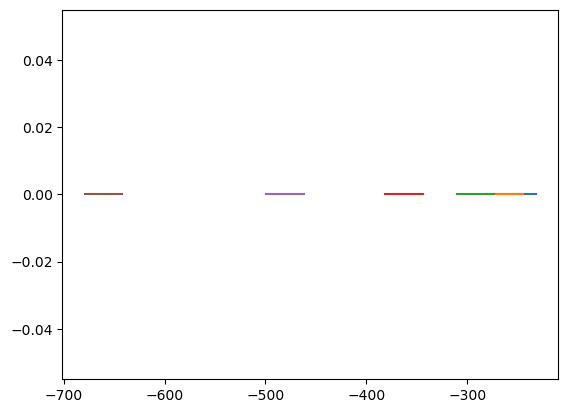

In [23]:
for aa,aa_item in ref_antero_playlist.items():
    y = np.mean(antero[aa],axis=0)
    x = np.arange(len(y))
    x = x - x[-1]
    plt.plot(x,y)

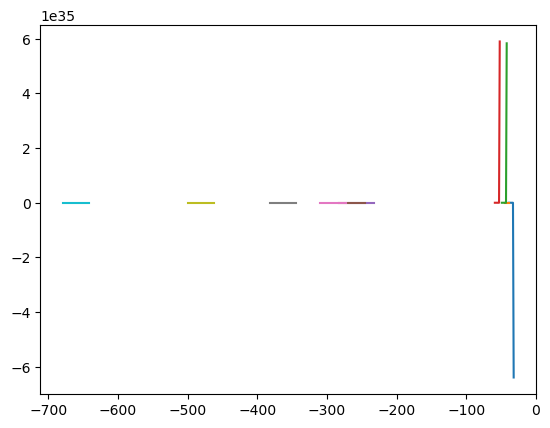

In [24]:
for aa,A_time in enumerate(A_times):
    y = np.mean(antero_short[aa],axis=0)
    x = np.arange(len(y))
    x = x - x[-1]
    plt.plot(x,y)

for aa,aa_item in ref_antero_playlist.items():
    y = np.mean(antero[aa],axis=0)
    x = np.arange(len(y))
    x = x - x[-1]
    plt.plot(x,y)

In [25]:
frog_ens = [True,False]
Tfrog = 400
frogs   = {aa: [ wrapped_runner([(1 if not frog_en else np.linspace(0,1,Tfrog),Tfrog),(0,40)],opt_data[k][pooling_fun]['x']) for k in opt_data] for aa,frog_en in enumerate(frog_ens)}

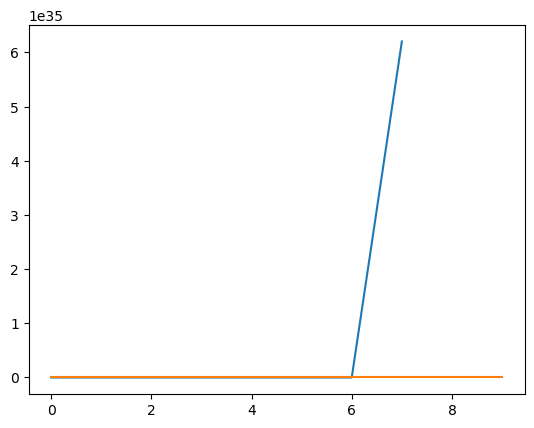

In [26]:
for frog_en in frog_ens:
    plt.plot(np.mean(frogs[frog_en],axis=0))

In [27]:
from siggen_utils import herzfeld_block


def generate_herzfeld_scenarios(z_list=None, n_blocks=None, Tflips=None): 
    out_dict = {}
    for z in z_list:
        scenario_name =  f'herzfeld,z={z}'
        pert_per_z = []
        for n in range(n_blocks):
            hz = herzfeld_block(z, P1=Pplus,P2=Pminus,P0=P0, tau=1)
            pert_per_z.append((hz,len(hz)))
        out_dict.update({scenario_name:pert_per_z})
    return out_dict

hrz_params = {'z_list': [0.1,0.5,0.9], 'n_blocks': 25}
hrz_playlist =  generate_herzfeld_scenarios(**hrz_params)
# her_results   = {aa: [ wrapped_runner(aa_item,opt_data[k][pooling_fun]['x']) for k in opt_data] for aa,aa_item in hrz_playlist.items()}

In [28]:
her_results   = {aa: [ wrapped_runner(aa_item,opt_data[k][pooling_fun]['x']) for k in opt_data] for aa,aa_item in hrz_playlist.items()}

KeyboardInterrupt: 

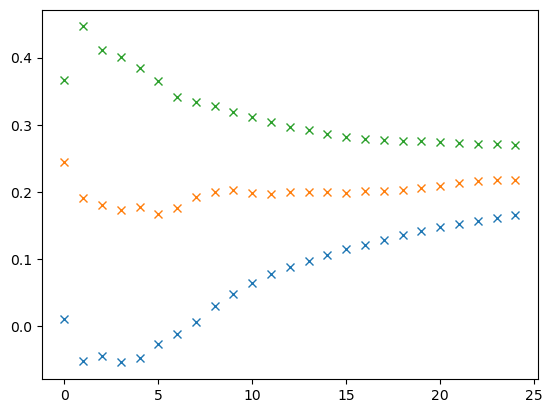

In [ ]:
for iz, z in enumerate(hrz_params['z_list']):
    deltas = []
    mm = lambda x: np.mean(x,axis=0)
    scenario = f'herzfeld,z={z}'
    this_result = her_results[scenario]
    pointer = 0
    for bb in range(hrz_params['n_blocks']):
        block_length = hrz_playlist[scenario][bb][-1]
        pointer += block_length
        deltas.append(mm(her_results[scenario])[pointer-1]-mm(her_results[scenario])[pointer-3])            

    plt.plot(deltas,'x',label = f'z={z}')


# for frog_en in frog_ens:
#     plt.plot(np.mean(frogs[frog_en],axis=0))

In [ ]:
playlist = {'Ac':[(P0, 200),(Pplus, 200),(Pchannel,200)],
            'ABc':[(P0, 200),(Pplus, 200),(Pminus, 200),(Pchannel,200)]}

results   = {aa: [ wrapped_runner(aa_item,opt_data[k][pooling_fun]['x']) for k in opt_data] for aa,aa_item in playlist.items()}

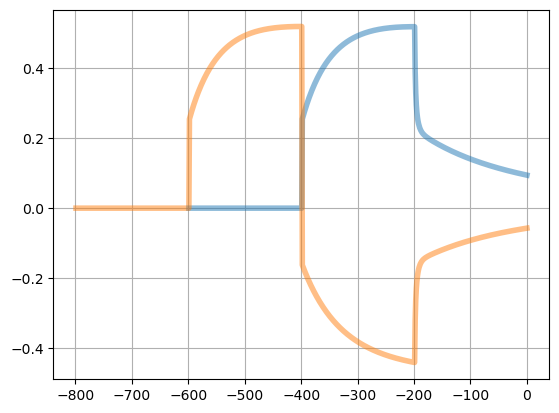

In [ ]:
for aa,aa_item in results.items():
    y = np.mean(results[aa],axis=0)
    x = np.arange(len(y))
    x = x - x[-1]
    plt.plot(x,y, linewidth=4, alpha=0.5)
plt.grid()

In [ ]:
from dsp_utils import parse_samples

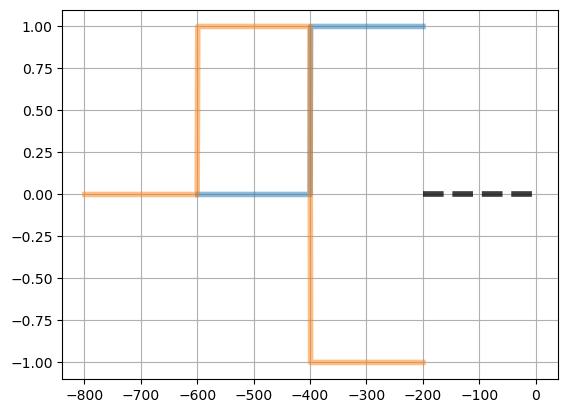

In [ ]:
for aa,aa_item in playlist.items():
    y = parse_samples(playlist[aa])
    x = np.arange(len(y))
    x = x - x[-1]    
    plt.plot(x,y, linewidth=4, alpha=0.5)
    #get a vector where nans replaced by 0 and every non-nan replaced by nan
    y_nan = np.nan*np.ones(len(y))
    y_nan[np.isnan(y)] = 0
    plt.plot(x,y_nan, 'k--',linewidth=4, alpha=0.5)
plt.grid()

In [ ]:
parse_samples(playlist[aa])

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0